### Exercise 1 --- Practical application of regression using neural networks

This exercise involves predicting the drag coefficient of an bump from its shape parameters. 

  * There are four input parameters ($x_1, x_2, x_3, x_4$) which correspond to the coordinate of two control points
  * The goal is to predict the drag coeffecient of the bump ($c_d$)
  * There is a training dataset (bump_data.h5)
  * Use 80% of the data for training and the rest for testing
  * Plot the loss function

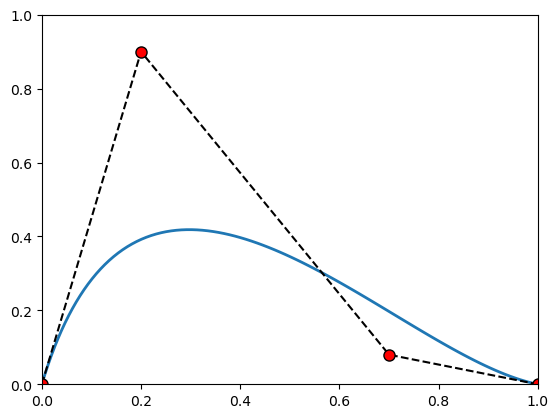

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def geom(x1, y1, x2, y2):
    P0 = np.array([0, 0])
    P1 = np.array([x1, y1])
    P2 = np.array([x2, y2])
    P3 = np.array([1, 0])
    t = np.linspace(0, 1, 100)
    P = np.zeros((100, 2))
    for i in range(100):
        pa = (1 - t[i]) * ((1 - t[i]) * P0 + t[i] * P1) + t[i] * ((1 - t[i]) * P1 + t[i] * P2)
        pb = (1 - t[i]) * ((1 - t[i]) * P1 + t[i] * P2) + t[i] * ((1 - t[i]) * P2 + t[i] * P3)
        P[i] = (1 - t[i]) * pa + t[i] * pb
    return P         

x1, y1 = 0.200, 0.9
x2, y2 = 0.700, 0.08
P = geom(x1, y1, x2, y2)
# plot the curve and the control points
plt.plot(P[:, 0], P[:, 1], lw=2)
#plt.scatter([0.0, x1, x2, 1.0], [0.0, y1, y2, 0.0], c='red', s=100)
plt.plot([0.0, x1, x2, 1.0], [0.0, y1, y2, 0.0], 'k--', marker='o', markerfacecolor='red', markersize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Solution steps :
* Import necessary packages/modules  (&check; code from tutorial)
* Dataset creation -- training and testing 
* Define and initialize a fully-connected neural network (&check; code from tutorial)
* Training and testing functions  (&check; code from tutorial)
* Train the neural network (&check; code from tutorial)
* Plot the loss function (&check; code from tutorial)

Hyperparameters:
* Input dimension = 4
* Output dimension = 1
* Net width = 10
* Net depth = 5
* Learning rate = 0.01
* Batch size = 20
* Optimizer = Adam


#### Import relevant modules

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_default_dtype(torch.float64)
import h5py

print("PyTorch version: ", torch.__version__)
print("Imported moduules successfully")

PyTorch version:  2.5.1
Imported moduules successfully


#### Dataset -- Training and testing data creation

In [13]:
with h5py.File('./assets/bump_data.h5','r') as data:
    X = np.array(data['X'], dtype=np.float64)
    y = np.array(data['y'], dtype=np.float64)

n_data = X.shape[0]
n_train = int(0.8*n_data)
n_test = n_data - n_train

X_train = torch.tensor(X[:n_train], dtype=torch.float64)
y_train = torch.tensor(y[:n_train], dtype=torch.float64).squeeze()
X_test = torch.tensor(X[n_train:], dtype=torch.float64)
y_test = torch.tensor(y[n_train:], dtype=torch.float64).squeeze()

print("Data loaded successfully")
print("Training data shape: ", X_train.shape, y_train.shape)
print("Testing data shape: ", X_test.shape, y_test.shape)

Data loaded successfully
Training data shape:  torch.Size([802, 4]) torch.Size([802])
Testing data shape:  torch.Size([201, 4]) torch.Size([201])


#### Neural network -- Creation and initialization

In [14]:
class NeuralNetwork(torch.nn.Module):
    '''
    Class for a feedforward neural network
    '''
    def __init__(self, input_dim=2, output_dim=1, width=5, depth=3, activation='relu'): #The values after = just means the default values if user does not specify
        super().__init__()
        self.input_dim = input_dim          # input dimension, stores the values as part of the object 
        self.output_dim = output_dim        # output dimension
        self.width = width                  # width of hidden layers
        self.depth = depth                  # number of hidden layers + output layer
        if activation == 'relu':       #Set the activation function 
            self.activation = torch.nn.ReLU()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        else:
            raise ValueError('activation must be one of "relu", "tanh", or "sin"')
        
        self.modules = [] #Empty list to hold all the layers of the network
        self.modules.append(torch.nn.Linear(input_dim, width))  # input layer - takes 'input_dim' inputs, and outputs 'width' number of outputs 
        self.modules.append(self.activation)                    # activation function
        for _ in range(depth-1):                                # the _ means that the iteration variable, say i, is not needed in the loop
            self.modules.append(torch.nn.Linear(width, width))  # add hidden layers
            self.modules.append(self.activation)                # activation function
        
        self.modules.append(torch.nn.Linear(width, output_dim)) # output layer, takes in 'width' inputs and outputs 'output_dim' number of outputs
        self.net = torch.nn.Sequential(*self.modules)           # combines all layers, * unpacks the list ie. if layers = [layer1, layer2, layer3], then 
                                                                # (*layers) is the same thing as passing in (layer1, layer2, layer3) manually

        
    def forward(self, x):
        return self.net(x)

#### Training and testing functions

In [15]:
def train_network(net, train_loader, test_loader, epochs, optim, loss_fn, verbose=True):
    train_loss = []  # store training loss
    test_loss = []   # store test loss
    train_loss.append(test_network(net, train_loader, loss_fn))     # evaluate loss on training data before training the network
    test_loss.append(test_network(net, test_loader, loss_fn))       # evaluate loss on test data before training the network
    net.train()
    for epoch in range(epochs):                                     # loop over the dataset multiple times
        for x, y in train_loader:                                   # loop over each mini-batch
            optim.zero_grad()                                       # zero the parameter gradients
            y_pred = net(x)                                         # forward pass
            loss = loss_fn(y_pred, y.unsqueeze(1))                  # compute loss
            loss.backward()                                         # backward pass
            optim.step()                                            # update weights
        if epoch % 100 == 0:                                        # print loss every 100 epochs
            test_loss_ = test_network(net, test_loader, loss_fn)     # evaluate loss on test data
            train_loss_ = test_network(net, train_loader, loss_fn)   # evaluate loss on training data
            train_loss.append(train_loss_)                           # store training loss
            test_loss.append(test_loss_)                             # store test loss
            if verbose:                                         
                print(f'Epoch {epoch}, Train Loss {train_loss_:.3f}, Test Loss {test_loss_:.3f}') # print loss
            

    # Evaluate loss on training and test data after training the network
    train_loss.append(test_network(net, train_loader, loss_fn))
    test_loss.append(test_network(net, test_loader, loss_fn))
    return net, train_loss, test_loss # return trained network and loss

def test_network(net, test_loader, loss_fn):
    net.eval()                                                  # set the network to evaluation mode (deactivates dropout and batch normalization)
    with torch.no_grad():                                       # deactivate autograd engine (reduce memory consumption)
        loss = 0.                                               # initialize loss
        for x, y in test_loader:                                # loop over each mini-batch
            y_pred = net(x)                                     # forward pass
            loss += loss_fn(y_pred, y.unsqueeze(1)).item()      # compute loss
    net.train()                                                 # set the network back to training mode
    return loss / len(test_loader)                              # return average loss

#### Neural network -- Training and evaluation/testing

Total number of parameters: 25
Epoch 0, Train Loss 0.012, Test Loss 0.011
Epoch 100, Train Loss 0.003, Test Loss 0.003
Epoch 200, Train Loss 0.003, Test Loss 0.003
Epoch 300, Train Loss 0.004, Test Loss 0.003
Epoch 400, Train Loss 0.004, Test Loss 0.003
Epoch 500, Train Loss 0.003, Test Loss 0.003
Epoch 600, Train Loss 0.004, Test Loss 0.003
Epoch 700, Train Loss 0.003, Test Loss 0.003
Epoch 800, Train Loss 0.003, Test Loss 0.003
Epoch 900, Train Loss 0.003, Test Loss 0.003
Epoch 1000, Train Loss 0.004, Test Loss 0.003
Epoch 1100, Train Loss 0.004, Test Loss 0.003
Epoch 1200, Train Loss 0.004, Test Loss 0.003
Epoch 1300, Train Loss 0.004, Test Loss 0.003
Epoch 1400, Train Loss 0.003, Test Loss 0.003
Epoch 1500, Train Loss 0.004, Test Loss 0.003
Epoch 1600, Train Loss 0.003, Test Loss 0.003
Epoch 1700, Train Loss 0.004, Test Loss 0.003
Epoch 1800, Train Loss 0.004, Test Loss 0.003
Epoch 1900, Train Loss 0.004, Test Loss 0.003
Final train loss: 0.0036226378534650267
Final test loss: 0.00

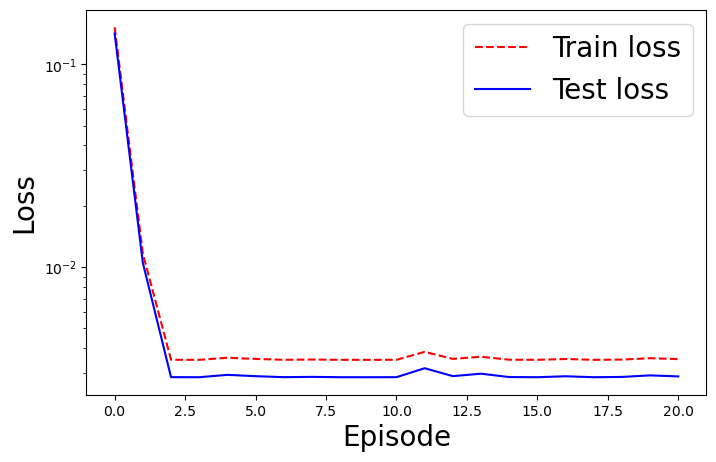

In [17]:
batch_size = 20
n_epochs = 2000
lr = 0.001

# Create data loaders for training and test data
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

# Create the neural network
net_width = 2
net_depth = 3
net_activation = 'relu'

net = NeuralNetwork(input_dim = 4, width=net_width, depth=net_depth, activation=net_activation)
print('Total number of parameters:', sum(p.numel() for p in net.parameters())) #print total number of parameters
# print(net) #print the network architecture

# Define the loss function and the optimizer
loss_func = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train the network
net, train_loss, test_loss = train_network(net, train_loader, test_loader, n_epochs, optimizer, loss_func)
torch.save(net.state_dict(), 'bump_model.pth') # save the trained model

print('Final train loss:', train_loss[-1])
print('Final test loss:', test_loss[-1])

# Plot the training and test loss
plt.figure(figsize=(8, 5))
plt.plot(train_loss[:-1], label='Train loss', linestyle='--', color='r')
plt.plot(test_loss[:-1], label='Test loss', linestyle='-', color='b')
plt.yscale('log')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [ ]:
input_X = torch.tensor(X, dtype=torch.float64)
y_pred = net(input_X).detach().numpy()

# Create a figure with foure subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))

# First subplot: scatter plot of xP1 and yP1, colored by predicted Cd
sc1 = ax1.scatter(X[:,0], X[:,1], c=y_pred, cmap='viridis', marker='o')
ax1.set_title(r'Scatter plot of $x_1$ and $y_1$')
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$y_1$')
fig.colorbar(sc1, ax=ax1, label=r'$\hat{C}_d$')

# Second subplot: scatter plot of xP2 and yP2, colored by predicted Cd
sc2 = ax2.scatter(X[:,2], X[:,3], c=y_pred, cmap='viridis', marker='o')
ax2.set_title(r'Scatter plot of $x_2$ and $y_2$')
ax2.set_xlabel(r'$x_2$')
ax2.set_ylabel(r'$y_2$')
fig.colorbar(sc2, ax=ax2, label=r'$\hat{C}_d$')


# Third subplot: scatter plot of xP1 and yP1, colored by true Cd
sc1 = ax3.scatter(X[:,0], X[:,1], c=y, cmap='viridis', marker='o')
ax3.set_title(r'Scatter plot of $x_1$ and $y_1$')
ax3.set_xlabel(r'$x_1$')
ax3.set_ylabel(r'$y_1$')
fig.colorbar(sc1, ax=ax3, label='Cd')

# Second subplot: scatter plot of xP2 and yP2, colored by true Cd
sc2 = ax4.scatter(X[:,2], X[:,3], c=y, cmap='viridis', marker='o')
ax4.set_title(r'Scatter plot of $x_2$ and $y_2$')
ax4.set_xlabel(r'$x_2$')
ax4.set_ylabel(r'$y_2$')
fig.colorbar(sc2, ax=ax4, label='Cd')

# Adjust layout
plt.tight_layout()